<a href="https://colab.research.google.com/github/ecrunch/haystack_tests/blob/main/SyntheticGenAIData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%%capture
!pip install sodapy
!pip install -U langchain langchain_experimental openai

In [15]:
#packages needed
import pandas as pd
from sodapy import Socrata
from sklearn.model_selection import train_test_split
import numpy as np
import os
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.pydantic_v1 import BaseModel
from langchain_experimental.tabular_synthetic_data.base import SyntheticDataGenerator
from langchain_experimental.tabular_synthetic_data.openai import create_openai_data_generator, OPENAI_TEMPLATE
from langchain_experimental.tabular_synthetic_data.prompts import SYNTHETIC_FEW_SHOT_SUFFIX, SYNTHETIC_FEW_SHOT_PREFIX
from datetime import datetime
from google.colab import userdata
import seaborn as sns
import matplotlib.pyplot as plt

#Dataset
crime = 'x2n5-8w5q'

#Client
client = Socrata("data.cityofchicago.org", None)



Get Dataset

In [78]:
results = client.get(crime, limit=1000000)
results_df = pd.DataFrame.from_records(results)
#remove columns that start with ':@'
results_df = results_df.loc[:, ~results_df.columns.str.startswith(':@')]
#drop location from result_df
results_df = results_df.drop(columns=['location'])
#remove starting "_" from column names when applicable
results_df.columns = results_df.columns.str.lstrip('_')
#convert date_of_occurrence to datetime
results_df

,case_,date_of_occurrence,block,iucr,primary_decsription,secondary_description,location_description,arrest,domestic,beat,ward,fbi_cd,x_coordinate,y_coordinate,latitude,longitude
0,JG407686,2023-09-02T05:09:00.000,032XX N HALSTED ST,0460,BATTERY,SIMPLE,COMMERCIAL / BUSINESS OFFICE,Y,N,1924,44,08B,1170348,1921937,41.941286092,-87.649308375
1,JG407689,2023-09-02T05:12:00.000,020XX E 70TH ST,041A,BATTERY,AGGRAVATED - HANDGUN,SIDEWALK,N,N,331,5,04B,1191215,1858962,41.76799787,-87.574660496
2,JG407698,2023-09-02T05:17:00.000,051XX W ROSCOE ST,0810,THEFT,OVER $500,STREET,N,N,1634,31,06,1141463,1922119,41.942368924,-87.755468366
3,JG407709,2023-09-02T05:25:00.000,132XX S INDIANA AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,N,Y,533,9,08B,1179935,1817750,41.655172319,-87.617262702
4,JG407710,2023-09-02T05:30:00.000,006XX S SACRAMENTO BLVD,0497,BATTERY,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS ...,SIDEWALK,N,Y,1135,28,04B,1156465,1897134,41.873517205,-87.701005851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258004,JH418048,2024-08-31T00:00:00.000,029XX W 82ND ST,0810,THEFT,OVER $500,RESIDENCE,N,Y,835,18,06,NaN,NaN,NaN,NaN
258005,JH409152,2024-08-31T00:00:00.000,011XX N KEYSTONE AVE,041A,BATTERY,AGGRAVATED - HANDGUN,SIDEWALK,N,N,1111,37,04B,1149176,1907349,41.901692505,-87.727502852
258006,JH409227,2024-08-31T00:00:00.000,063XX W 64TH PL,0560,ASSAULT,SIMPLE,APARTMENT,N,N,812,13,08A,1135292,1861078,41.774975343,-87.779596898
258007,JH409190,2024-08-31T00:00:00.000,044XX S DREXEL BLVD,0320,ROBBERY,STRONG ARM - NO WEAPON,STREET,N,N,221,4,03,1182936,1875860,41.814563821,-87.604481355


Get Metadata of Dataset

In [7]:
metadata = client.get_metadata(crime)

In [79]:
metadata = client.get_metadata(crime)
#create dictionary of metadata['columns'] only including fieldName,dataTypeName, description, AND cachedContents
metadata_dict = {}
for column in metadata['columns']:
    # Check if the fieldName starts with ':@' if so skip
    if column['fieldName'].startswith(':@'):
        continue
    if column['fieldName'] == 'location':
        continue
    # Check if the fieldName starts with '_' remove the '_'
    if column['fieldName'].startswith('_'):
        column['fieldName'] = column['fieldName'][1:]

    metadata_dict[column['fieldName']] = {'dataTypeName': column['dataTypeName']}
    if 'description' in column:
        metadata_dict[column['fieldName']]['description'] = column['description']
    if 'cachedContents' in column:
        metadata_dict[column['fieldName']]['cachedContents'] = column['cachedContents']

metadata_dict

{'case_': {'dataTypeName': 'text',
  'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.  ',
  'cachedContents': {'largest': 'LG449816',
   'non_null': '258009',
   'null': '0',
   'top': [{'item': 'JG499426', 'count': '3'},
    {'item': 'JH165644', 'count': '3'},
    {'item': 'JH327052', 'count': '3'},
    {'item': 'JG490649', 'count': '3'},
    {'item': 'JH332664', 'count': '3'},
    {'item': 'JH232120', 'count': '2'},
    {'item': 'JH277783', 'count': '2'},
    {'item': 'JH284448', 'count': '2'},
    {'item': 'JG538547', 'count': '2'},
    {'item': 'JH333940', 'count': '2'},
    {'item': 'JG510509', 'count': '2'},
    {'item': 'JH362433', 'count': '2'},
    {'item': 'JH373821', 'count': '2'},
    {'item': 'JG453003', 'count': '2'},
    {'item': 'JH290818', 'count': '2'},
    {'item': 'JH100028', 'count': '2'},
    {'item': 'JH314834', 'count': '2'},
    {'item': 'JH317789', 'count': '2'},
    {'item': 'JH208794', 'count

Function for creating schema class from metadata (Not Working at the moment)


In [11]:
def create_class_from_metadata(metadata_dict):
    """
    Create a Pydantic class based on the provided metadata dictionary.
    """
    fields = {}
    for field_name, field_info in metadata_dict.items():
        data_type = field_info['dataTypeName']
        if data_type == 'number':
            field_type = float
        elif data_type == 'text':
            field_type = str
        elif data_type == 'calendar_date':
            field_type = datetime
        else:
            field_type = str  # Default to string for unknown types
        fields[field_name] = field_type

    # Dynamically create the class
    class_name = "GeneratedClass"  # Or any suitable name
    GeneratedClass = type(class_name, (BaseModel,), fields)
    return GeneratedClass

In [43]:
crime_schema = create_class_from_metadata(metadata_dict)
crime_schema

abc.GeneratedClass

In [110]:
for field_name, field_info in metadata_dict.items():
  print(f"{field_name}: {field_info['dataTypeName']}")

case_: text
date_of_occurrence: calendar_date
block: text
iucr: text
primary_decsription: text
secondary_description: text
location_description: text
arrest: text
domestic: text
beat: number
ward: number
fbi_cd: text
x_coordinate: text
y_coordinate: text
latitude: number
longitude: number


In [92]:
class CrimeChicago(BaseModel):
  case_: str
  date_of_occurrence: datetime
  block: str
  iucr: str
  primary_description: str
  secondary_description: str
  location_description: str
  arrest: str
  domestic: str
  beat: int
  ward: int
  fbi_cd: str
  x_coordinate: float
  y_coordinate: float
  latitude: float
  longitude: float

In [63]:
#view crime_schema
print(crime_schema.__doc__)

None


In [16]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [49]:
def convert_to_examples(df):
  """Converts a DataFrame to a list of dictionaries with examples."""
  examples = []
  for _, row in df.iterrows():
    example = []
    for col in df.columns:
      example.append(f'{col}: {row[col]}')
    examples.append({"example": "" + ", ".join(example) + ""})
  return examples

In [101]:
#randomly pick 1000 rows from results_df and make another df
results_df_sample = results_df.sample(n=75)
#convert to examples
examples = convert_to_examples(results_df_sample)


In [82]:
examples

[{'example': 'case_: JH147472, date_of_occurrence: 2024-02-10T11:30:00.000, block: 043XX W NORTH AVE, iucr: 0560, primary_decsription: ASSAULT, secondary_description: SIMPLE, location_description: LIBRARY, arrest: N, domestic: N, beat: 2534, ward: 36, fbi_cd: 08A, x_coordinate: 1147450, y_coordinate: 1910287, latitude: 41.909787953, longitude: -87.733767284'},
 {'example': 'case_: JG463259, date_of_occurrence: 2023-10-14T00:30:00.000, block: 018XX W 71ST ST, iucr: 1320, primary_decsription: CRIMINAL DAMAGE, secondary_description: TO VEHICLE, location_description: STREET, arrest: N, domestic: N, beat: 735, ward: 17, fbi_cd: 14, x_coordinate: 1165470, y_coordinate: 1857603, latitude: 41.764852996, longitude: -87.669066019'},
 {'example': 'case_: JH173411, date_of_occurrence: 2024-03-03T01:16:00.000, block: 055XX N MOBILE AVE, iucr: 0560, primary_decsription: ASSAULT, secondary_description: SIMPLE, location_description: APARTMENT, arrest: N, domestic: Y, beat: 1622, ward: 45, fbi_cd: 08A,

Prompt Template

In [102]:
OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

prompt_template = FewShotPromptTemplate(
    prefix=SYNTHETIC_FEW_SHOT_PREFIX,
    examples=examples,
    suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
    input_variables=["subject", "extra"],
    example_prompt=OPENAI_TEMPLATE,
)

In [103]:
synthetic_data_generator = create_openai_data_generator(
    output_schema=CrimeChicago,
    llm=ChatOpenAI(temperature=1),
    prompt=prompt_template,
)

In [104]:
synthetic_results = synthetic_data_generator.generate(
    subject="chicago_crime",
    extra="""The block must be chosen at random but must be in Chicago. Make it something you wouldn't normally choose,
     but follow the format that block uses in the example. For case_,_iucr,_primary_decsription,_secondary_description,and _location_description
     follow the trends examples but randomize it.""",
    runs=25,
)

In [105]:
synthetic_results

[CrimeChicago(case_='AB123456', date_of_occurrence=datetime.datetime(2025, 9, 10, 8, 15), block='081XX S WOLCOTT AVE', iucr='1350', primary_decsription='CRIMINAL DAMAGE', secondary_description='TO CITY OF CHICAGO PROPERTY', location_description='PARKING LOT', arrest='N', domestic='N', beat=721, ward=21, fbi_cd='14', x_coordinate=1174092.0, y_coordinate=1851246.0, latitude=41.747933, longitude=-87.672819),
 CrimeChicago(case_='AB987654', date_of_occurrence=datetime.datetime(2025, 10, 15, 13, 30), block='052XX N RANDOM AVE', iucr='1320', primary_decsription='CRIMINAL DAMAGE', secondary_description='TO PROPERTY', location_description='ABANDONED BUILDING', arrest='N', domestic='N', beat=1832, ward=39, fbi_cd='14', x_coordinate=1175000.0, y_coordinate=1906000.0, latitude=41.899234, longitude=-87.636721),
 CrimeChicago(case_='AB765432', date_of_occurrence=datetime.datetime(2025, 11, 20, 9, 45), block='078XX S RAVENSWOOD AVE', iucr='2345', primary_decsription='CRIMINAL TRESPASS', secondary_de

In [106]:
synthetic_results_list = []
for result in synthetic_results:
    synthetic_results_list.append(result.dict())
synthetic_results_df = pd.DataFrame(synthetic_results_list)
synthetic_results_df

,case_,date_of_occurrence,block,iucr,primary_decsription,secondary_description,location_description,arrest,domestic,beat,ward,fbi_cd,x_coordinate,y_coordinate,latitude,longitude
0,AB123456,2025-09-10 08:15:00,081XX S WOLCOTT AVE,1350,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,PARKING LOT,N,N,721,21,14,1174092.0,1851246.0,41.747933,-87.672819
1,AB987654,2025-10-15 13:30:00,052XX N RANDOM AVE,1320,CRIMINAL DAMAGE,TO PROPERTY,ABANDONED BUILDING,N,N,1832,39,14,1175000.0,1906000.0,41.899234,-87.636721
2,AB765432,2025-11-20 09:45:00,078XX S RAVENSWOOD AVE,2345,CRIMINAL TRESPASS,TO LAND,ALLEY,N,N,723,33,26,1172345.0,1856789.0,41.756809,-87.673421
3,AB876543,2025-12-20 17:30:00,083XX S UNCOMMON AVE,2468,CRIMINAL DAMAGE,TO VEHICLE,ALLEY,N,N,835,17,14,1176000.0,1850000.0,41.744863,-87.683599
4,ZX987654,2025-11-30 14:00:00,092XX S UNUSUAL AVE,2467,ROBBERY,ARMED - KNIFE / CUTTING INSTRUMENT,GROCERY STORE,N,N,721,23,03,1174000.0,1851000.0,41.747205,-87.672931
5,AB246810,2025-12-10 15:45:00,077XX N RAINBOW AVE,1350,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,ALLEY,N,N,1832,39,14,1175500.0,1905500.0,41.894321,-87.638179
6,ZY987654,2025-11-30 10:30:00,1234 W RANDOM ST,1355,ROBBERY,AGGRAVATED - FIREARM,PUBLIC PARK,N,N,721,21,03,1174000.0,1851000.0,41.747205,-87.672931
7,YZ987123,2025-11-30 08:00:00,1234 W UNCOMMON AVE,1355,ROBBERY,AGGRAVATED - FIREARM,ALLEY,N,N,721,21,03,1174000.0,1851000.0,41.747205,-87.672931
8,AB135792,2025-12-01 14:30:00,1234 W MYSTERY AVE,1345,ROBBERY,"AGGRAVATED - HANDS, FISTS, FEET",ALLEY,N,N,721,21,03,1174000.0,1851000.0,41.747205,-87.672931
9,AB987123,2025-11-30 08:00:00,098XX W MYSTICAL AVE,2345,ASSAULT,"AGGRAVATED - HANDS, FISTS, FEET",CITY PARKING GARAGE,N,N,721,21,04A,1174000.0,1851000.0,41.747205,-87.672931


In [107]:
results_df_sample

,case_,date_of_occurrence,block,iucr,primary_decsription,secondary_description,location_description,arrest,domestic,beat,ward,fbi_cd,x_coordinate,y_coordinate,latitude,longitude
179092,JH267025,2024-05-17T10:40:00.000,047XX N LINDER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,N,Y,1623,45,08B,1138810,1931086,41.967023885,-87.765000914
231115,JH360065,2024-07-24T15:51:00.000,129XX S ESCANABA AVE,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,433,10,08A,1197426,1819767,41.660290667,-87.553196521
257615,JH408460,2024-08-30T14:07:00.000,044XX N DRAKE AVE,0430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,N,N,1723,33,04B,1151921,1929354,41.962022392,-87.716838881
40355,JG479910,2023-10-26T05:45:00.000,006XX N FRANKLIN ST,0610,BURGLARY,FORCIBLE ENTRY,BAR OR TAVERN,N,N,1831,42,05,1174211,1904618,41.893676531,-87.635628328
165477,JH241791,2024-04-28T04:39:00.000,038XX S VINCENNES AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,N,Y,212,4,08B,1180733,1879480,41.82454837,-87.61245073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190398,JH301725,2024-06-01T04:00:00.000,0000X W DIVISION ST,031A,ROBBERY,ARMED - HANDGUN,STREET,N,N,1824,2,03,1175877,1908368,41.903929378,-87.62939674
77686,JG545904,2023-12-18T00:00:00.000,008XX N LA SALLE DR,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,N,N,1832,2,11,1174994,1905840,41.897012256,-87.632716018
249550,JH393692,2024-08-18T17:00:00.000,020XX N CALIFORNIA AVE,0920,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,ALLEY,N,N,1414,1,07,1157367,1913715,41.918998658,-87.697242802
47320,JG491356,2023-11-04T14:14:00.000,071XX S UNION AVE,051A,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,N,N,732,6,04A,1172982,1857614,41.764720689,-87.641532131


In [108]:
synthetic_results_df['synthetic'] = True
results_df_sample['synthetic'] = False

In [114]:
#combine synthetic_results_df and results_df_sample
combined_df = pd.concat([synthetic_results_df, results_df_sample])
combined_df

,case_,date_of_occurrence,block,iucr,primary_decsription,secondary_description,location_description,arrest,domestic,beat,ward,fbi_cd,x_coordinate,y_coordinate,latitude,longitude,synthetic
0,AB123456,2025-09-10 08:15:00,081XX S WOLCOTT AVE,1350,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,PARKING LOT,N,N,721,21,14,1174092.0,1851246.0,41.747933,-87.672819,True
1,AB987654,2025-10-15 13:30:00,052XX N RANDOM AVE,1320,CRIMINAL DAMAGE,TO PROPERTY,ABANDONED BUILDING,N,N,1832,39,14,1175000.0,1906000.0,41.899234,-87.636721,True
2,AB765432,2025-11-20 09:45:00,078XX S RAVENSWOOD AVE,2345,CRIMINAL TRESPASS,TO LAND,ALLEY,N,N,723,33,26,1172345.0,1856789.0,41.756809,-87.673421,True
3,AB876543,2025-12-20 17:30:00,083XX S UNCOMMON AVE,2468,CRIMINAL DAMAGE,TO VEHICLE,ALLEY,N,N,835,17,14,1176000.0,1850000.0,41.744863,-87.683599,True
4,ZX987654,2025-11-30 14:00:00,092XX S UNUSUAL AVE,2467,ROBBERY,ARMED - KNIFE / CUTTING INSTRUMENT,GROCERY STORE,N,N,721,23,03,1174000.0,1851000.0,41.747205,-87.672931,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190398,JH301725,2024-06-01T04:00:00.000,0000X W DIVISION ST,031A,ROBBERY,ARMED - HANDGUN,STREET,N,N,1824,2,03,1175877,1908368,41.903929378,-87.62939674,False
77686,JG545904,2023-12-18T00:00:00.000,008XX N LA SALLE DR,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,N,N,1832,2,11,1174994,1905840,41.897012256,-87.632716018,False
249550,JH393692,2024-08-18T17:00:00.000,020XX N CALIFORNIA AVE,0920,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,ALLEY,N,N,1414,1,07,1157367,1913715,41.918998658,-87.697242802,False
47320,JG491356,2023-11-04T14:14:00.000,071XX S UNION AVE,051A,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,N,N,732,6,04A,1172982,1857614,41.764720689,-87.641532131,False


In [112]:
#save combined_df to csv
combined_df.to_csv('chicago_crime_synthetic.csv', index=False)

In [119]:


def plot_categorical_distribution(data, feature, synthetic_col='synthetic'):
  """
  Plots the distribution of a categorical feature for both original and synthetic data.

  Args:
    data: DataFrame containing the data.
    feature: Name of the categorical feature to plot.
    synthetic_col: Name of the column indicating whether the data is synthetic.
  """
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.countplot(y=feature, hue=synthetic_col, data=data, palette='coolwarm')
  plt.title(f'{feature} Distribution')
  plt.ylabel(feature)
  plt.xlabel('Count')
  plt.legend(title='synthetic')
  plt.show()

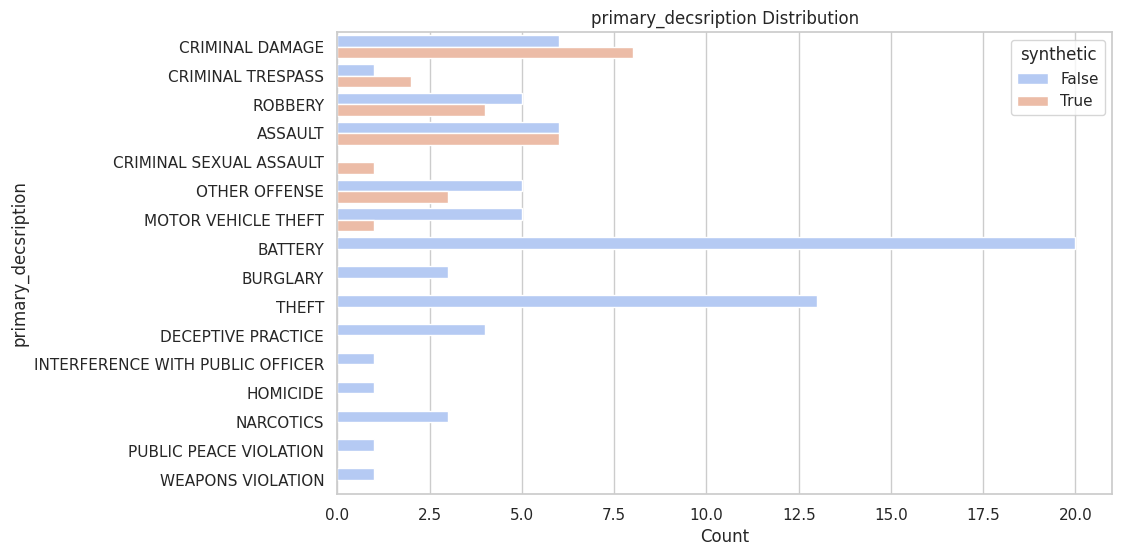

In [120]:
plot_categorical_distribution(combined_df, 'primary_decsription')


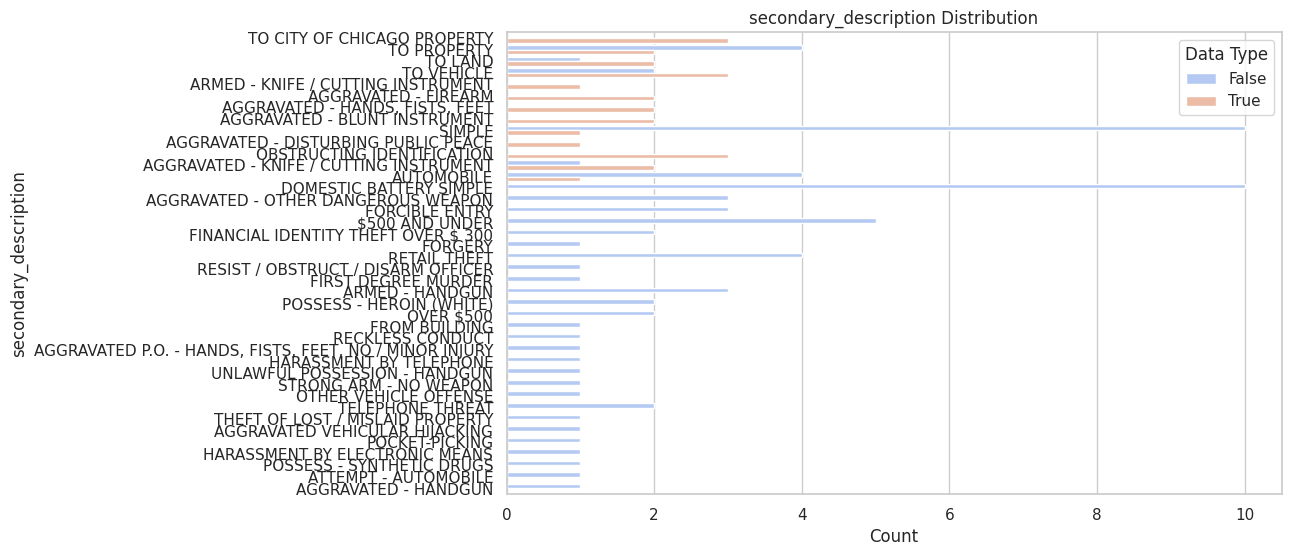

In [117]:
plot_categorical_distribution(combined_df, 'secondary_description')


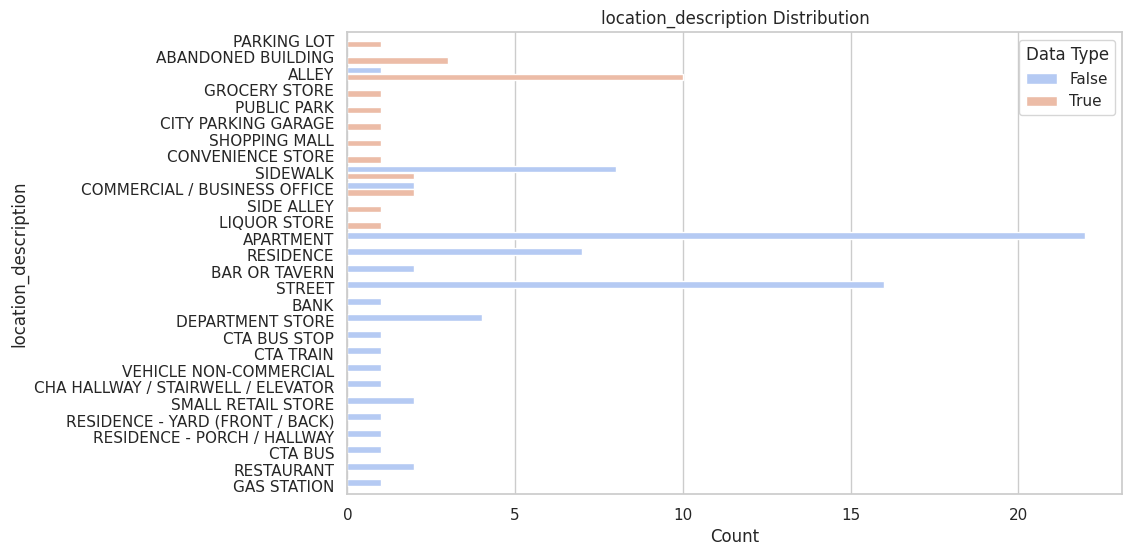

In [118]:
plot_categorical_distribution(combined_df, 'location_description')

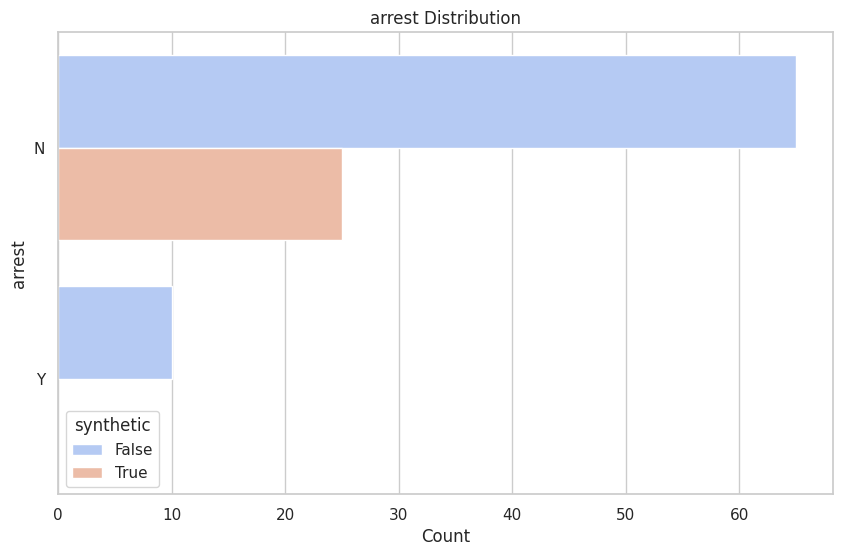

In [121]:
plot_categorical_distribution(combined_df, 'arrest')

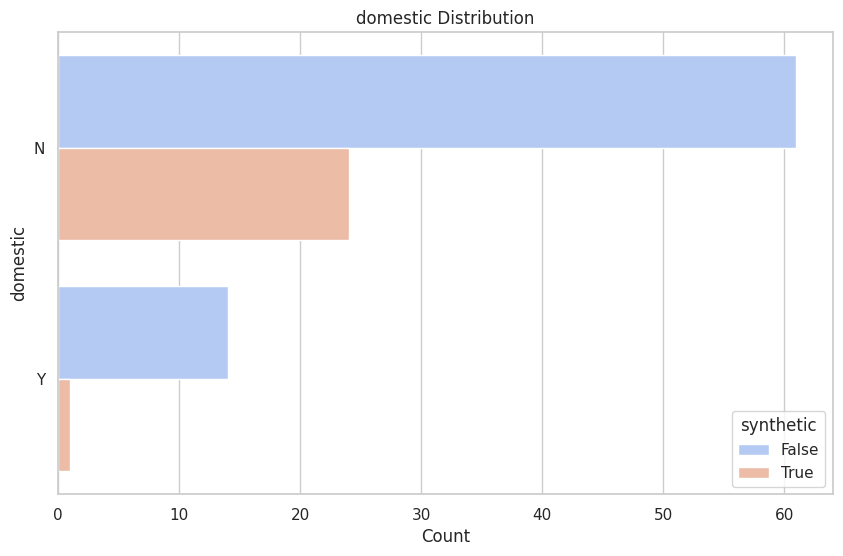

In [122]:
plot_categorical_distribution(combined_df, 'domestic')